# Problem Statement

The business problem is to "Maximize _future_ total return (sales - cost) by changing hourly budgets". This includes the following:

1. If roas and cost are both known, then optimizing total return is simple. Where roas is highest, spend as much on advertising as can be purchased. Where roas is < 1, don't spend anything on advertising. The challenge is that roas and cost are not both known and need to be estimated (or "forecasted"). Additionally, we don't have any data to begin with, so assumptions must be made at the beginning until data are gathered.
1. Once I've defined a way to estimate tomorrow's roas and cost, I need rules to allocate my budget. I need to take into account that I want to run a campaign for many days and that the campaign's budget should run out the day the campaign ends. Also, I need to always be gathering data as roas and cost change over time. Some budget needs to be allocated for learning and gathering data, some for optimizing revenue.
1. Make it very easy for customers to define 1) a budget and 2) a campaign duration and let them 'set it and forget it'.

Redefined, I see this problem as:

* Without any information on the ad performance of the company, have a good method for discovering what `roas` will be in each hour of tomorrow. Once I have enough data, rely on observed data rather than uninformed intuition.
* Be able to detect quickly the hours that have the best roas.
* Support the intuition behind a/b testing, where you find the best hours, but your algorithm is flexible to adjust to changing environments. While you want to allocate 100% of daily `budget` to the hour

I break down these problems into Stage 0, 1 and 2 problems. Some of which I'll solve in this assessment, others which I won't.

**Stage 0** problems are those that arise before we begin.

* Provide a simple interface where a customer can supply 1) a quarterly budget and 2) a campaign length and the system will automate all of the decisions in the background.
* We _might_ know something about our population, or our users might know something from past campaigns. I would like to provide users the opportunity to define expected roas and cost for each our and "strength of conviction" behind those expectations. Over time, the observed data should override that initial belief. 
    * In my assessment, I assume uniform distribution to begin with.


**Stage 1**, or cold start problem until my optimization starts working. The main problem is understanding the distribution behind mean `roas` $\mu_{roas}$, and mean `cost`, $\mu_{cost}$. If I know the true $\mu_{roas}$ and $\mu_{cost}$, then I know how to optimize my budget. 

* Roas determines profit. To have the highest profit each day, you would, ideally, allocate 100% of available budget to the hours with the highest `roas`. To have ad spend profit in any hour, you need `roas > 1`. When `roas = 1`, I break even.
* I will only spend minimal budget where the return is not profitable for data collection only.
* Budget can be a safety valve. When `0 <= roas < 1`, you want to minimize budget.
* Budget can be a constraint on total return. For your best hourly `roas`, you want to maximize your cost. If `hourly_budget < cost` for the peak hourly `roas`, you lost money. Since cost can be a limiting factor, I then want to allocate as much budget as cost will allow and use remaining budget across other profitable roas hours. 
* Daily vs. weekly, vs. monthly budget. Each customer will have different budget constraints. From our conversation on the phone, I assume here that there are quarterly budgets that need to be spent in full. 
    * A naive approach would be to take quarterly budget/90 = daily budget. This is naive because if we have no information on the customers' ad performance, we want to spend a little money in the first few weeks, experimenting with budget until we learn $\mu_{cost}$ and $\mu_{roas}$.
    * Alternatively, I could dynamically adjust my budget. Spend a small amount of budget in the first few days in order to gather data. I can allocate more budget over time as I gain confidence in my data and feel confident in my ability to predict tomorrow's cost.
* non-stationary hours. 1) Good `roas` might migrate within-day from 7pm to 8pm, as per the `CampaignHour._shuffle_config()` method. In this simulator, the assumption is that cost-roas pair remains the same _within-day_, but might change across hours. Therefore, if this non-stationarity can be detected and appropriately modeled, the overall budget for that day should remain the same. 2) Overall cost-roas for all hours, across days and weeks could die. This is not presently simulated. In such a case, the budget needs to be saved for when cost-roas returns to expected levels. In both cases, when a change is detected, a new strategy needs to override the existing one.

**Stage 2** or second-order, problems are the problems that happen once you "influence" your system and bias your data as a result. Since we're repeatedly experimenting on our customers by trying out new budget, new ads, etc., we influence our customers to assume something. 

* Heavily advertising at certain times (allocating large budget to specific hours) might teach customers when to shop. If we advertise heavily at 8pm because we see 60% of customers shop then and it has good `roas`, over time the a portion of the remaining 40% of customers might start shopping at 8pm and our `roas` might degrade. Other hours might then become the best hours for `roas`.
* Who you advertise to is who you have data about. Who you don't advertise to is the population that you don't understand. If you inadvertantly market only to city-dwellers, then you only have data on city dwellers. Perhaps suburbanites could be better served at different times. The solution is constant experimentation and targeted experimentation to learn the $\mu_{roas}$ and $\mu_{cost}$ for each subpopulation.

> To solve this problem, our algorithm needs to "test" with new areas constantly. The daily profit-maximizing stategy would be to allocation 100% of budget to the best hour. If hourly `cost` and `roas` do not change, this is the lifetime-maximizing strategy. But if `cost` and `roas` evolve as we advertise, we need to constantly allocate experimentation budget to new hours to ensure that our estimates are correct.

Assumptions made but not addressed by this modeling approach:

* You can't have sales without costs. The way the simulator and `default_hourly_config` are set up, and since `sales = cost * roas`, I assume that you cannot have sales without ad spending. This is not a realistic constraint if you have reasonable organic SEO, but the purpose of this assignment is to maximize budget allocation and optimize ad spend. In reality, this would be an additional subproblem: how to differentiate between organic and ad-driven sales. (Perhaps this is easy on Amazon: was the "sponsored" ad clicked or not?)
* Hourly `roas` rates are relatively constant (except for non-stationarity). In this assignment, we assume that `roas` is a fixed parameter and doesn't change with weekday, holidays, season, competition, price, shipping costs (if you market to a remote location, you need to ship the package to a remote location), customer demographic (sex, geography, age). In reality, `roas` is affected by many things, and can possibly be changing. The simplified modeling approach presented in this assignment assumes that 1) the true hourly `roas` is unknown and needs to be estimated and 2) has a distribution that is unchanging. By "unchanging", I do not mean has no variance. I mean that the variance and mean are known parameters. 
    * In the case of non-stationarity, something could always drive a change in sales (such as a competitor product emerging). The model used can adjust for this.


# Modeling Approach

How do I model cost and roas?

* Time series data. Cost for an hour is correlated with the cost from the same hour in prior days. It's also correlated with the neighboring hours in the day. I generally assume that if sales are peak at 9pm, they'd also be decent at 8pm or 10pm. I could imagine scenarios where this wouldn't be the case, such as if you have sales on a given hour (which encourages extra spend in that hour).
* Cold-start problem (no upfront data): This is solved by assuming some distribution about roas and cost _a priori_.
* Normally distributed: According to the simulator, roas and cost are normally distributed (trucated at 0 for cost and has an upper-bound of budget). This isn't always the case in reality, but it's a simplifying assumption in this model.

Modeling approach of choice:

* Bayesian Hierarchical model (BHM):
    * Bayesian hierarchical models are extremely flexible. They allow you to encode your intuition into the model and easily adjust for lack of data (assume some prior knowledge about the customer).
    * Stan is a great probabilistic programming language for modeling hierarchical models. It's written in C, but can be called fromm R, Python, and other languages. Here's a chapter on time-series using Stan: [Link to time series chapter](https://mc-stan.org/docs/2_18/stan-users-guide/time-series-chapter.html.)
    * I chose to implement a BHM using a Gibbs Sampler. Documentation on Gibbs Samplers isn't as easy to find. I could have used the JAGS programming language, which uses Gibbs samplers on the backend. Instead, I decided to code it by hand since I have prior experience with this.
        * Paper: [Gibbs Sampling for the Uninitiated](https://drum.lib.umd.edu/bitstream/handle/1903/10058/gsfu.pdf?sequence=3&isAllowed=y)
        * General Introduction to Gibbs Samplers: [Gibbs Sampling](http://www.mit.edu/~ilkery/papers/GibbsSampling.pdf)
        * Here's some intuition on Gibbs Samplers for General Linear Models: https://arxiv.org/pdf/0712.3056.pdf
    * The attached materials I provided are useful for understanding the intuition behind the model used in this example.
    * The BHM I've implemented assumes a few things about the data:
        * Each hour is correlated with the ones before and after it.
        * Each hour has it's own variance. Alternatively, I could assume that all hours have the same variance, or even the same mean. (You might want to assume that hours 7-10 have the same distribution and hours 3-6 have their own, etc. Through testing, you'd see what performs the best.)

# Other Approaches Considered

I considered the following modeling approaches before settling on my final approach.

* ARIMA:
    * ARIMA are good at time series prediction. 
    * Similar to taking the moving average under certain hyperparameter constraints.
    * Is good at handling seasonality: consistently known spikes.
    * Doesn't provide as good measurements of uncertainty as BHM.
* Linear Regression with lagged features:
    * Build a linear regression with lagged variables can be a very simple, powerful way to get good predictions. For example: COST at Hour J = Beta0 + Beta1 * (X1 = Cost at Hour J on Day - 1) + Beta2 * (X2 = Cost at Hour J-1 on Day -1 ) + Beta3 * (X3 = Cost at Hour J + 1 on Day - 1).
    * You need data to estimate the future, however. So this approach isn't good when you don't have data. A potential work-around would be to invent fake data for a few days and then once you've gathered data, train the model only on true data.
    
Other approaches completely new to me that I would be cautious about implementing without expertise:

* Long Short-term Memory Network (LSTM): 
    * Good at time series. 
    * Wrappers provided in Keras
    * LSTM can "forget" over time, which allows you to adjust for non-stationarity: https://www.mitpressjournals.org/doi/pdf/10.1162/089976600300015015
    * Tutorial on how to get started. https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
* Reinforcement learning: Great at optimization (if given a lot of data). 
* Multi-armed bandits:
    * Good at testing and adjusting over time.
    * Similar to reinforcement learning.
    * Used for dynamic pricing: https://www.gsb.stanford.edu/sites/gsb/files/mkt_10_17_misra.pdf
    * Tutorial on MABs: https://www.analyticsvidhya.com/blog/2018/09/reinforcement-multi-armed-bandit-scratch-python/
* Gaussian Process (GP) Regression: 
    * GPs are great when you have little data.
    * GPs are flexible.
    * If I were to model a GP here, I'd model the hours in the day (starting from 0, going to 23). In the other time series approaches above, I'd probably model the data longitudinally: across days. Both modeling approaches could work, but I think the GP would do better by modeling hours in the day because that would enforce a dependence on nearby hours.
    * It'd be a little hard to adjust for non-stationarity, though I'm not an expert here.
    * GPs can be implemented in Stan: https://mc-stan.org/docs/2_18/stan-users-guide/gaussian-processes-chapter.html#gaussian-processes.chapter
    * sk-learn documentation: https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_noisy_targets.html
   

# Results
Below, I demonstrated my results.

In [1]:
import sys
sys.path.append('..')
import numpy as np
import pandas as pd
import plotnine as g # imports all ggplot2 commands

from src.mcmc import MCMC
from src.optimizer import OptimizeBudget
# Campaign() extracted for confidentiality reasons. This notebook
# is for demonstrations only

# for replicability
np.random.seed(42)

In [2]:
# User-defined inputs (would go on Downstream.com's UI)

# total to be spent in the quarter/campaign
campaign_budget = 10000
# length of campaign
n_days = 100

A note on computational complexity: This code is not optimized for computational complexity since running `campaign.get_data_as_df()` each iteration is unnecessarily burdensom. In the future, I would update the `Campaign` class to store the last-day's cost as a callable method. I didn't want to change `Campaign`, for Downstream's simplicity.  

Also, the model is refitting after each day, so each model is using up-to-the-day information. This has a cost.

This code can take up to 30 minutes to run. If you want to re-run for testing, I suggest starting with a shorter campaign (10 days). Or reduce `niter` to a smaller amount.

In [3]:
# Assume "Naive" approach: uniformly distributed budget across days and hours
unif_campaign = Campaign()
unused_budget = campaign_budget
for d in range(n_days):
    days_remaining = n_days - d
    hourly_budgets = [unused_budget/(24 * days_remaining) for i in range(24)]
    unif_campaign.run_campaign_for_single_day(hourly_budgets)
    # subtract only used budget
    unused_budget = campaign_budget - unif_campaign.get_data_as_df().cost.sum()
    print('Day:', d, 
          'Budget allocated today:', np.sum(hourly_budgets), 
          'Remaining budget:', unused_budget)

Day: 0 Budget allocated today: 100.0 Remaining budget: 9953.474708814992
Day: 1 Budget allocated today: 100.54014857388881 Remaining budget: 9911.177111274732
Day: 2 Budget allocated today: 101.13446031912991 Remaining budget: 9854.841944386731
Day: 3 Budget allocated today: 101.59630870501786 Remaining budget: 9802.743844820472
Day: 4 Budget allocated today: 102.11191505021324 Remaining budget: 9754.35367789186
Day: 5 Budget allocated today: 102.6774071357038 Remaining budget: 9706.489431528684
Day: 6 Budget allocated today: 103.26052586732641 Remaining budget: 9648.723919260397
Day: 7 Budget allocated today: 103.74971956193976 Remaining budget: 9606.852573164764
Day: 8 Budget allocated today: 104.42231057787787 Remaining budget: 9557.731763899146
Day: 9 Budget allocated today: 105.0300193835071 Remaining budget: 9502.775220135765
Day: 10 Budget allocated today: 105.58639133484184 Remaining budget: 9443.969149101613
Day: 11 Budget allocated today: 106.11201291125408 Remaining budget: 

Day: 95 Budget allocated today: 657.5542056910103 Remaining budget: 3140.020818312687
Day: 96 Budget allocated today: 785.0052045781717 Remaining budget: 3010.5024699422383
Day: 97 Budget allocated today: 1003.5008233140795 Remaining budget: 2830.7909542029074
Day: 98 Budget allocated today: 1415.3954771014537 Remaining budget: 2662.358900629526
Day: 99 Budget allocated today: 2662.358900629526 Remaining budget: 2342.273174914827


In [4]:
# Run my Bayesian Hierarchical Model
print('Starting BHM:')
m_bayes = OptimizeBudget(quarterly_budget=campaign_budget, campaign_duration=n_days, model_type='bayes', mcmc_niter=500)
m_bayes.execute_campaign()

# Compare BHM to a simple 10-day moving average
print('Starting 10-day Moving Average:')
m_mean = OptimizeBudget(quarterly_budget=campaign_budget, campaign_duration=n_days, model_type='mean')
m_mean.execute_campaign()

Starting BHM:
Day: 0 Budget allocated today: 100.0 Remaining budget: 9950.037371464974
Day: 1 Budget allocated today: 99.50037371464974 Remaining budget: 9893.981717013974
Day: 2 Budget allocated today: 98.93981717013975 Remaining budget: 9849.84243467664
Day: 3 Budget allocated today: 98.49842434676641 Remaining budget: 9809.158697749817
Day: 4 Budget allocated today: 98.09158697749818 Remaining budget: 9761.524400732054
Day: 5 Budget allocated today: 488.07622003660276 Remaining budget: 9655.4611038163
Day: 6 Budget allocated today: 482.77305519081506 Remaining budget: 9538.714476168969
Day: 7 Budget allocated today: 476.9357238084485 Remaining budget: 9410.740190039909
Day: 8 Budget allocated today: 470.5370095019955 Remaining budget: 9325.772663020998
Day: 9 Budget allocated today: 466.2886331510499 Remaining budget: 9195.854741580486
Day: 10 Budget allocated today: 459.79273707902433 Remaining budget: 9128.562682869579
Day: 11 Budget allocated today: 456.4281341434789 Remaining bu

Day: 95 Budget allocated today: 941.5237900493136 Remaining budget: 4632.079321893239
Day: 96 Budget allocated today: 1158.0198304733096 Remaining budget: 4556.867751007445
Day: 97 Budget allocated today: 1518.9559170024816 Remaining budget: 4455.451877812147
Day: 98 Budget allocated today: 2227.7259389060737 Remaining budget: 4349.424682292373
Day: 99 Budget allocated today: 4349.424682292373 Remaining budget: 4254.410044773398
Starting 10-day Moving Average:
Day: 0 Budget allocated today: 100.0 Remaining budget: 9960.55098245501
Day: 1 Budget allocated today: 99.6055098245501 Remaining budget: 9919.249756895288
Day: 2 Budget allocated today: 99.19249756895287 Remaining budget: 9860.75075160329
Day: 3 Budget allocated today: 98.6075075160329 Remaining budget: 9806.495745143131
Day: 4 Budget allocated today: 98.06495745143131 Remaining budget: 9756.278324171177
Day: 5 Budget allocated today: 487.81391620855885 Remaining budget: 9620.52719217278
Day: 6 Budget allocated today: 481.026359

Day: 90 Budget allocated today: 537.1648552977597 Remaining budget: 5301.322916610637
Day: 91 Budget allocated today: 589.0358796234041 Remaining budget: 5245.9808480655
Day: 92 Budget allocated today: 655.7476060081875 Remaining budget: 5173.497538895392
Day: 93 Budget allocated today: 739.0710769850559 Remaining budget: 5106.592671086553
Day: 94 Budget allocated today: 851.0987785144256 Remaining budget: 5051.463228416926
Day: 95 Budget allocated today: 1010.2926456833851 Remaining budget: 4977.881582892305
Day: 96 Budget allocated today: 1244.4703957230763 Remaining budget: 4879.848295402845
Day: 97 Budget allocated today: 1626.616098467615 Remaining budget: 4800.995081232358
Day: 98 Budget allocated today: 2400.497540616179 Remaining budget: 4715.852991372904
Day: 99 Budget allocated today: 4715.852991372904 Remaining budget: 4571.61920571189


In [5]:
# Store outputs
bayes_res = m_bayes.campaign.get_data_as_df()
mean_res = m_mean.campaign.get_data_as_df()
unif_res = unif_campaign.get_data_as_df()

# Extract truth for comparison
df_truth = pd.DataFrame(unif_campaign.default_hourly_config)
df_truth.columns = ['true_cost', 'true_roas']
df_truth['hour'] = range(24)
display(df_truth.head())

# Store daily/hourly estimates for plotting
def extract_hourly_estimates(model, df_truth):
    df_est = pd.DataFrame()
    for d in range(n_days):
        tmp = pd.DataFrame(m_bayes.estimates[d])
        tmp['day'] = d
        # remove fake-data hours 0 and 25. I have 26 hours in my model. Explained in code. In the future, I'd clean this up.
        tmp = tmp.loc[~tmp.index.isin([0, 25]),] 
        tmp['hour'] = range(24) # re-index 
        df_est = df_est.append(tmp)

    df_est.columns = ['est_cost', 'est_roas', 'day', 'hour']
    return df_est.merge(df_truth, on='hour')

df_bhm = extract_hourly_estimates(m_bayes, df_truth)
df_ma = extract_hourly_estimates(m_mean, df_truth)
display(df_bhm.head())


,true_cost,true_roas,hour
0,5.1,0.05,0
1,0.0,0.00,1
2,0.0,0.00,2
3,0.5,0.50,3
4,0.0,0.00,4


,est_cost,est_roas,day,hour,true_cost,true_roas
0,4.166667,0.097154,0,0,5.1,0.05
1,4.156258,0.048577,1,0,5.1,0.05
2,2.770839,0.032385,2,0,5.1,0.05
3,3.104154,0.038143,3,0,5.1,0.05
4,3.300753,0.030514,4,0,5.1,0.05


In [6]:
# The bayes, uniform, and  mean campaign objects didn't have the same data! 
# the seed perhaps needs to be initialized in the campaign object
print(bayes_res.head())
print(mean_res.head())
print(unif_res.head())

   hour  day    budget      cost     sales      roas  total_return
0     0    0  4.166667  4.166667  0.404807  0.097154     -3.761859
1     1    0  4.166667  0.000000  0.000000  0.000000      0.000000
2     2    0  4.166667  0.000000  0.000000  0.000000      0.000000
3     3    0  4.166667  0.462439  0.446346  0.965200     -0.016093
4     4    0  4.166667  0.000000  0.000000  0.000000      0.000000
   hour  day    budget      cost     sales      roas  total_return
0     0    0  4.166667  1.038118  0.025534  0.024596     -1.012584
1     1    0  4.166667  0.000000  0.000000  0.000000      0.000000
2     2    0  4.166667  0.000000  0.000000  0.000000      0.000000
3     3    0  4.166667  0.122967  0.052119  0.423850     -0.070847
4     4    0  4.166667  0.000000  0.000000  0.000000      0.000000
   hour  day    budget      cost     sales      roas  total_return
0     0    0  4.166667  4.166667  0.185289  0.044469     -3.981377
1     1    0  4.166667  0.000000  0.000000  0.000000      0.00

In [7]:
# Format results
total_return = {
    'bayes': bayes_res.total_return.sum(),
    'mean': mean_res.total_return.sum(),
    'uniform': unif_res.total_return.sum(),
}

total_cost = {
    'bayes': bayes_res.cost.sum(),
    'mean': mean_res.cost.sum(),
    'uniform': unif_res.cost.sum()
}

total_sales = {
    'bayes': bayes_res.sales.sum(),
    'mean': mean_res.sales.sum(),
    'uniform': unif_res.sales.sum()
}

results = pd.DataFrame([total_sales, total_cost, total_return]).transpose()
results.columns = ['Total Sales', 'Total Cost', 'Total Return']
results['ROAS'] = results['Total Sales']/results['Total Cost']


# Results

I compared three methods, details of the implementation can be found in the code.

1. Estimate cost/roas using a Bayesian Gibbs Sampler. Optimize budget by allocating to highest roas hours (adjusting for max estimated allowed cost).
2. Estimate cost/roas using the 10-day average. Optimize budget by allocating to highest roas hours (adjusting for max estimated allowed cost).
3. Uniformly allocate budget across all hours of the day, across all days of the campaign.

In all three campaigns, I re-allocate any unused budget from the prior campaigns to the subsequent days.

I ran the campaign three times for 100 days, proposing a \\$10,000 budget for the entire campaign.

In [8]:
# Print out 
import tabulate
print(tabulate.tabulate(results, headers=results.columns, tablefmt='pipe'))

|         |   Total Sales |   Total Cost |   Total Return |    ROAS |
|:--------|--------------:|-------------:|---------------:|--------:|
| bayes   |       9795.75 |      5745.59 |        4050.16 | 1.70492 |
| mean    |       9419.57 |      5428.38 |        3991.19 | 1.73524 |
| uniform |      10118.9  |      7657.73 |        2461.2  | 1.3214  |


### Conclusions
* Both the BHM and 10-day MA perform better more than 2x better than Uniform. The Bayesian method only marginally improves over the total return. The Bayesian model could certainly be tuned for better performance. For now, the 10-day moving average does as good of a job as the complex BHM. 
    * In other testing, I saw better performance out of the BHM, up to 20\% better than the 10-day average. Of course, I'm disappointed it doesn't perform better on this run, but I want to present the honest results.
    * Although I set a seed, which will enable you to replicate these results, each campaign has a differ initial seed. Each algorithm is testing on different campaign data. The performance could be impacted by the fact that the models are testing on different data. To get a true apples-to-apples, the seed needs to be set in the Campaign object. I wasn't able to test this because of time, but perhaps Downstream could test this when reviewing my code.
* Uniform method spends more, which could be a good thing if it's spending more where roas > 1, but is a bad thing where roas < 1.
* The Uniform will perform terribly if many hours in the day have low roas and high cost. Bayes and 10-day MA will adjust for this because it mostly allocates budget where roas > 1.
* The BHM wasn't able to spend 100\% of the budget. This could be good because some hours might have low cost where roas > 1. It's bad if hours have a really high cost (\\$5,000) where roas > 1. That means I'm missing out on good spend.

### Future work

* The problem is that I wasn't able to fully identify the areas that had the highest possible costs.
* One way to "better discover" areas of high true costs (with good roas) is to allocate more budget earlier on to testing. For example, my code will test for 20 days and then it'll distribute the budget across the remainin 80 days of the campaign. This limits my ability to maximize profits because I might only be spending \\$180 per day. If the upper limit on cost is \\$5000, it might take a long time before the estimator is able to identify this highly-spikey location. To improve testing, I could allocate more budget randomly among all hours that have positive roas, rather than in the waterfall pattern I've implemented. Perhaps one day, I allocate 100\% of budget to one hour, and 100\% of budget to the next. Then I'd have data on the upper-limit of cost. 
* Since I'm using a Bayesian method, it would be very easy to get confidence intervals (known as credible intervals in the Bayesian paradigm) on my predictions for the following day. I could adjust my decision engine to have some measure of uncertainty. For example, I might estimate that expected roas the next day would be 1.1 with a range between 0.8 and 1.4. I might want to allocate less budget here. Also, if I'm uncertain about my cost estimates, I could improve my algorithm to take the upper-bound of estimated cost where roas > 1. For example, if I estimate cost at \\$100, but has a 95\\% CI between \\$80 and \\$120 (and if roas > 1), I could allocate \\$120 of budget instead of just \\$100.

# Model Diagnostics

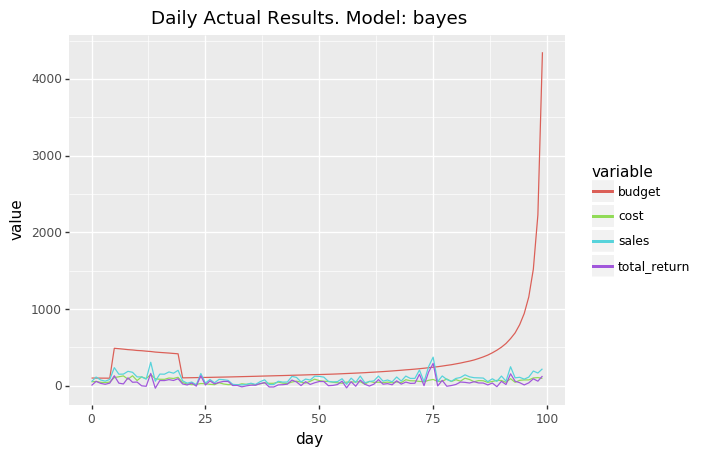

<ggplot: (-9223372036556035889)>

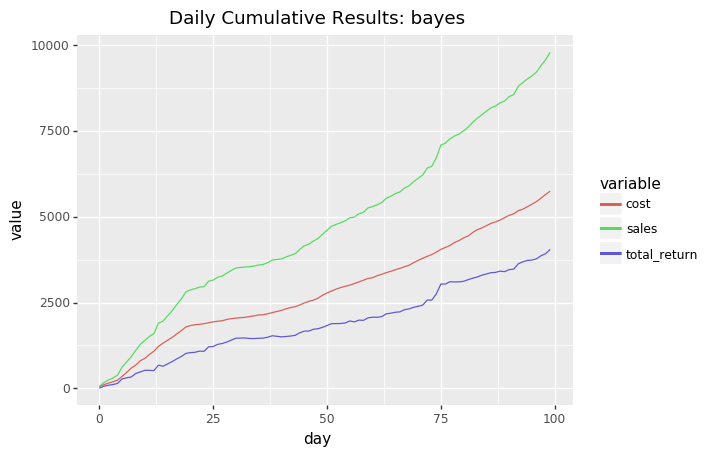

<ggplot: (-9223372036556019470)>

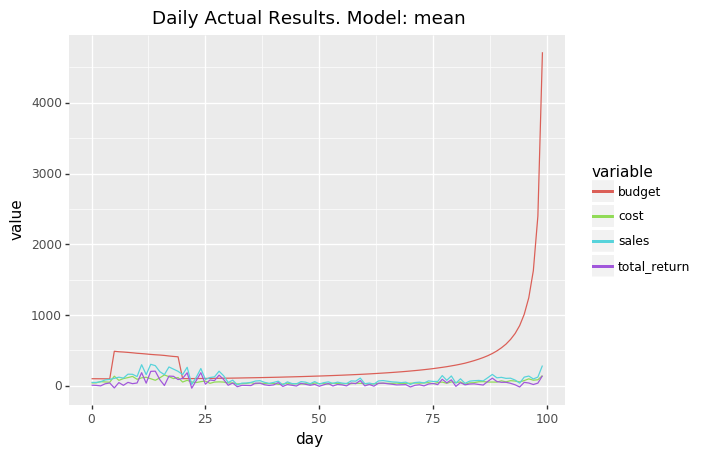

<ggplot: (-9223372036556019498)>

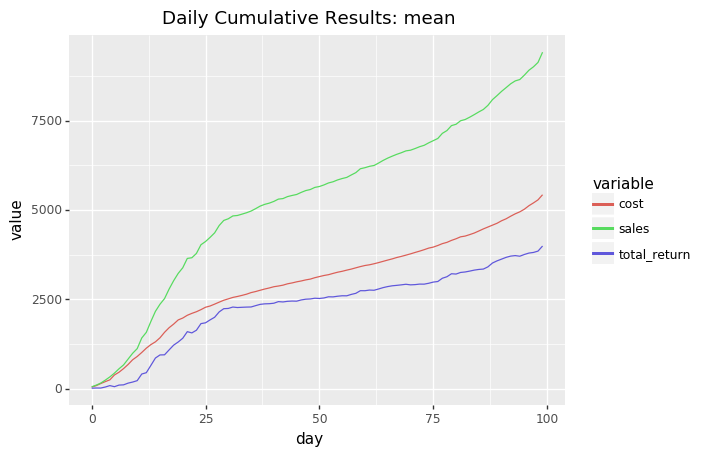

<ggplot: (-9223372036556019901)>

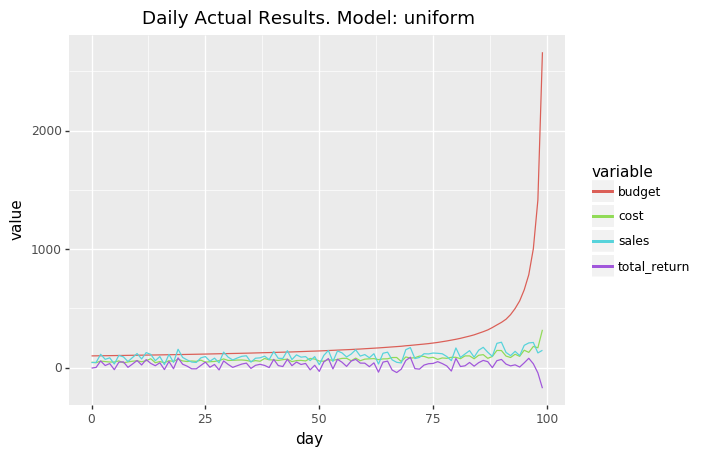

<ggplot: (-9223372036553885850)>

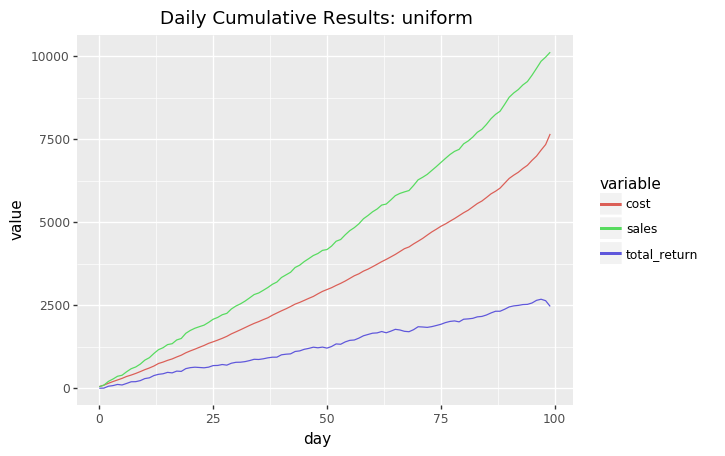

<ggplot: (-9223372036556017653)>

In [9]:
# Plot campaign stats over time
for m in ['bayes', 'mean', 'uniform']:
    if m == 'bayes':
        model = bayes_res
    elif m == 'mean':
        model = mean_res
    else:
        model = unif_res
    
    totals_by_day = model.groupby('day').agg({'budget': 'sum', 
                                              'total_return': 'sum', 
                                              'sales': 'sum', 
                                              'cost': 'sum'}).reset_index()

    # plot the results
    display(g.ggplot(totals_by_day.melt('day'), g.aes(x='day', y='value', color='variable')) + 
            g.geom_line() + 
            g.ggtitle(f'Daily Actual Results. Model: {m}')
           )

    for var in ['total_return', 'sales', 'cost']:
        totals_by_day[var] = totals_by_day[var].cumsum()
    totals_by_day = totals_by_day[['day', 'total_return', 'sales', 'cost']]

    display(g.ggplot(totals_by_day.melt('day'), g.aes(x='day', y='value', color='variable')) + 
            g.geom_line() + 
            g.ggtitle(f'Daily Cumulative Results: {m}')
           )


### Assess model performance visually

Plot the estimated Roas vs. the True Roas (and cost). The truth is extracted from the campaign object. These plots don't account for non-stationarity.

/Users/bryanwhiting/venvs/py37/lib/python3.7/site-packages/plotnine/layer.py:360: UserWarning: stat_summary : Removed 341 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)
/Users/bryanwhiting/venvs/py37/lib/python3.7/site-packages/plotnine/layer.py:360: UserWarning: stat_summary : Removed 341 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)
/Users/bryanwhiting/venvs/py37/lib/python3.7/site-packages/plotnine/layer.py:449: UserWarning: geom_errorbar : Removed 3 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


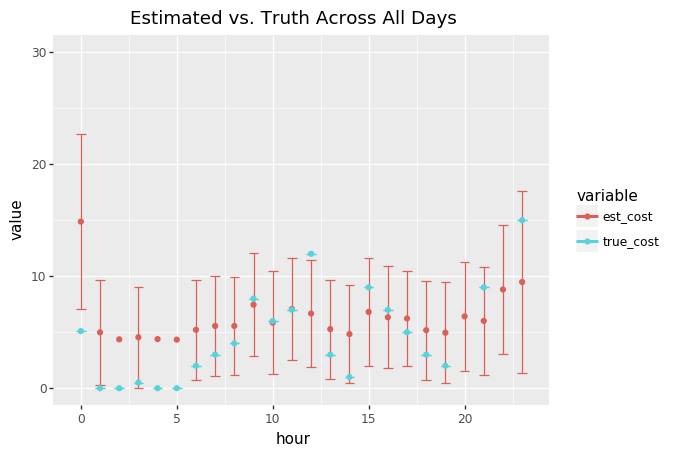

<ggplot: (301457854)>

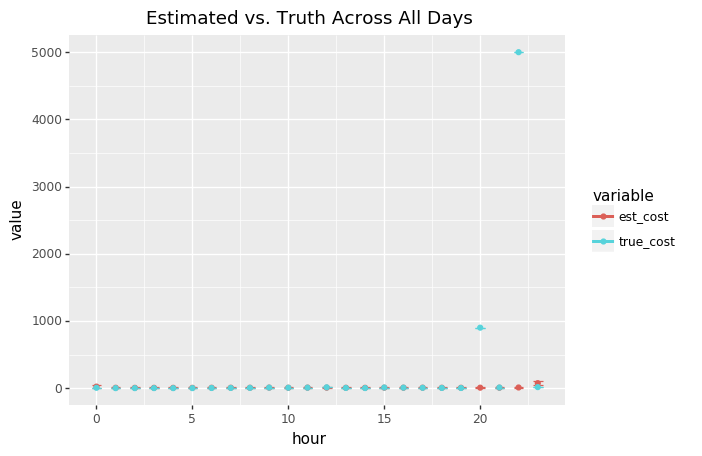

<ggplot: (-9223372036552795560)>

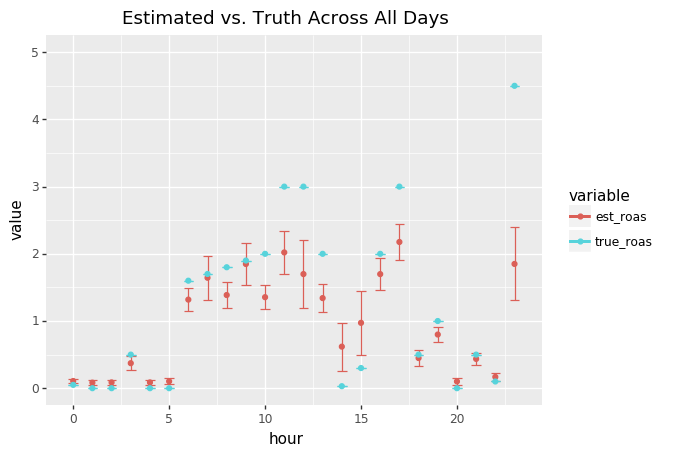

<ggplot: (-9223372036552794147)>

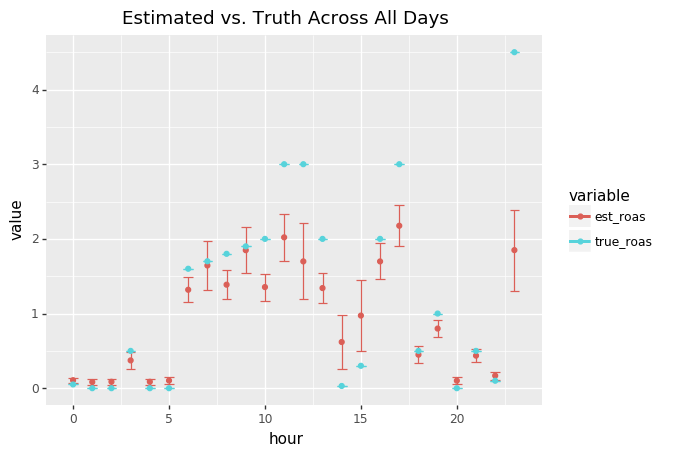

<ggplot: (-9223372036552499221)>

In [10]:
# NOTE: these plots don't take into account 
# for plotting - hide the outliers. Adjust as necessary
ylim_trunk_bounds = {
    'cost': 30,
    'roas': 5
}

for var in ['cost', 'roas']:
    tmp = df_bhm[[f'est_{var}', f'true_{var}', 'day', 'hour']].melt(['day', 'hour'])
    for truncate_yaxis in [True, False]:
        p = (g.ggplot(tmp, g.aes(x='hour', y='value', color='variable')) + 
                 g.stat_summary(fun_data = 'mean_sdl', fun_args = {'mult':1}, geom = 'errorbar') +
                 g.stat_summary(fun_y = np.mean, geom = 'point') + 
                 g.ggtitle('Estimated vs. Truth Across All Days') )
        if truncate_yaxis:
            p = p + g.ylim([0, ylim_trunk_bounds[var]])
        display(p)

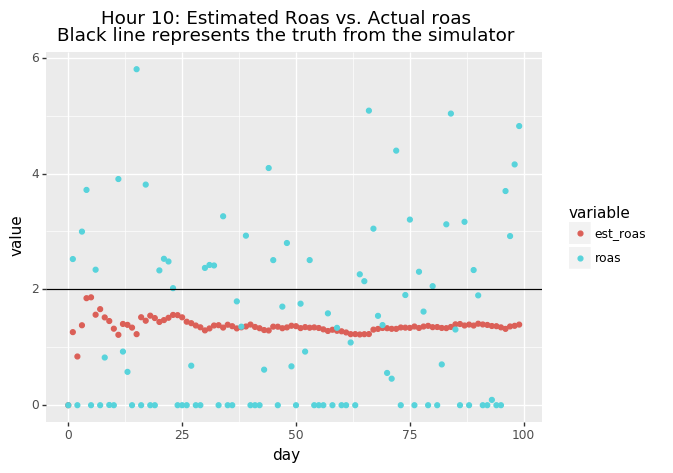

<ggplot: (301458836)>

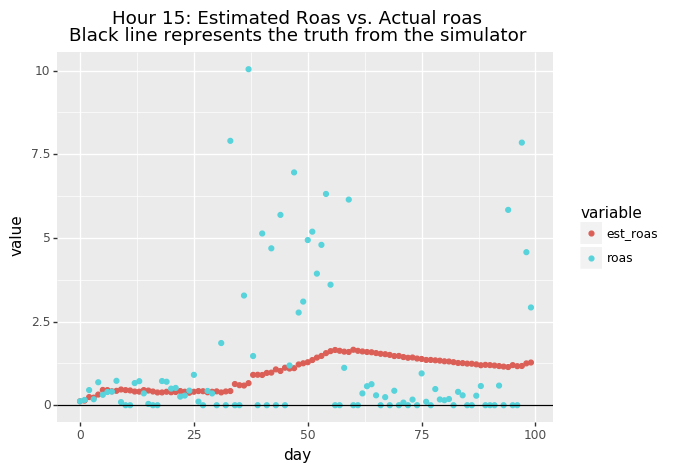

<ggplot: (-9223372036553469226)>

In [11]:
# d
tmp = bayes_res.merge(df_bhm[['day', 'hour', 'est_cost', 'est_roas']], on=['day', 'hour'])
for hour in [10, 15]:

    truth = int(df_truth[df_truth['hour'] == hour]['true_roas'].tolist()[0])

    df_plt = tmp[tmp['hour'] == hour][['day', 'roas', 'est_roas']].melt('day')
    display(g.ggplot(df_plt, g.aes(x='day', y='value', color='variable')) +
     g.geom_point() + 
     g.geom_hline(yintercept=truth) + 
     g.ggtitle(f'Hour {hour}: Estimated Roas vs. Actual roas\nBlack line represents the truth from the simulator')
    )

# Testing the MCMC algorithm

To test the MCMC Class to make sure it has relatively good ability to estimate different inputs, I used the following code. This can also provide a better understanding of how the estimator works.

In [12]:
# Testing the code (would do unit tests w/more time)
k = 26
n_fake_datapoints = 10
roas = {}
cost = {}
for i in range(0, k):
    # estimate an exponential distribution, which has a lower-bound of 0
    roas[i] = np.random.exponential(i * .1, n_fake_datapoints)
    # estimate a random normal distribution with means [0, 10, 20, 30, ..., 150]
    if i <= 15 or i > 20:
        cost[i] = np.random.normal(i * 10, 10, n_fake_datapoints)
    else:
        # after day 15, estimate mean of 10. This will test the model's ability to 
        # jump from a high prior hour to a low subsequent hour
        cost[i] = np.random.normal(5, 10, n_fake_datapoints)
        

In [13]:
# Fit the model for Roas

# pass in the data, which is a dictionary. each key is an hour, the values are the obtained datapoints
r_mcmc = MCMC(data=roas, niter=500)
# fit the model
r_mcmc.fit()

# Explore the estimates
print(r_mcmc.estimates_as_json()['theta'])

[[1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 1.00000000e+00
  1.00000000e+00 1.00000000e+00]
 [1.36675744e-01 4.14171330e-01 2.35635485e-01 ... 1.88754750e+00
  2.22976570e+00 2.18582644e+00]
 [0.00000000e+00 0.00000000e+00 4.69975276e-01 ... 1.79288677e+00
  2.75274363e+00 2.27805936e+00]
 ...
 [0.00000000e+00 1.44420961e-01 6.51528643e-01 ... 1.98091045e+00
  2.22793132e+00 1.68008802e+00]
 [5.34023774e-01 2.27454994e-03 7.62761185e-01 ... 1.66391638e+00
  1.82589357e+00 2.75738829e+00]
 [3.51537532e-02 0.00000000e+00 2.12206568e-01 ... 2.44196830e+00
  2.55229341e+00 2.44310283e+00]]


In [14]:
# remove the burnin-items. (Burnin is the "warm-up", period for the MCMC algorithm to start stabilizing)
r_mcmc.estimates_as_json_noburn()['theta']

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.31687743e+00, 2.36367062e+00, 2.63282090e+00],
       [0.00000000e+00, 2.58892523e-01, 0.00000000e+00, ...,
        2.42299078e+00, 1.88240446e+00, 1.32137091e+00],
       [1.84958751e-01, 0.00000000e+00, 0.00000000e+00, ...,
        1.36924980e+00, 2.44272380e+00, 2.53347692e+00],
       ...,
       [0.00000000e+00, 1.44420961e-01, 6.51528643e-01, ...,
        1.98091045e+00, 2.22793132e+00, 1.68008802e+00],
       [5.34023774e-01, 2.27454994e-03, 7.62761185e-01, ...,
        1.66391638e+00, 1.82589357e+00, 2.75738829e+00],
       [3.51537532e-02, 0.00000000e+00, 2.12206568e-01, ...,
        2.44196830e+00, 2.55229341e+00, 2.44310283e+00]])

In [15]:
# returns a mean estimate for each hour.
r_mcmc.mu
# In future versions, i could output the stdev and get 95% Confidence intervals (known as credible intervals in the bayesian works). 
# I could leverage these credible intervals in the 

{0: 0.21827194640808917,
 1: 0.19035442258302462,
 2: 0.26474023460192697,
 3: 0.26066204303772317,
 4: 0.40283606513473924,
 5: 0.6662894462303742,
 6: 1.1533083747645954,
 7: 0.4701291061217081,
 8: 0.6317976780525703,
 9: 0.6713416182905871,
 10: 0.5745214534829812,
 11: 0.8585220600152964,
 12: 0.7417634340235753,
 13: 1.892625566416765,
 14: 1.2193427852611303,
 15: 1.0040336008380863,
 16: 2.529386577730337,
 17: 1.4160395945048552,
 18: 1.2975745689243918,
 19: 1.5015815283620688,
 20: 1.7944282185117573,
 21: 2.5296026388705917,
 22: 2.5690529803065267,
 23: 1.9082926409630434,
 24: 2.306992290813986,
 25: 2.1847902954794214}

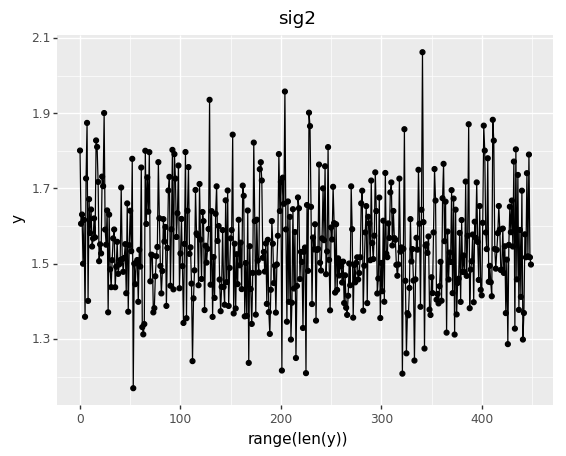

<ggplot: (298576041)>

In [16]:
# plot the trace plot for the variance parameter
r_mcmc.plot_sig2()

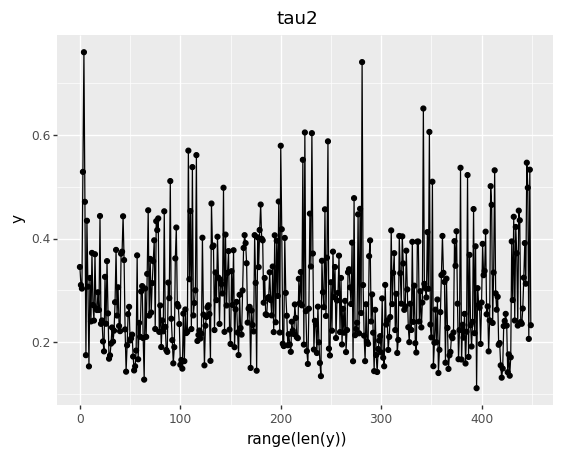

<ggplot: (298575971)>

In [17]:
# plot the trace plot for the other variance parameter
r_mcmc.plot_tau2()

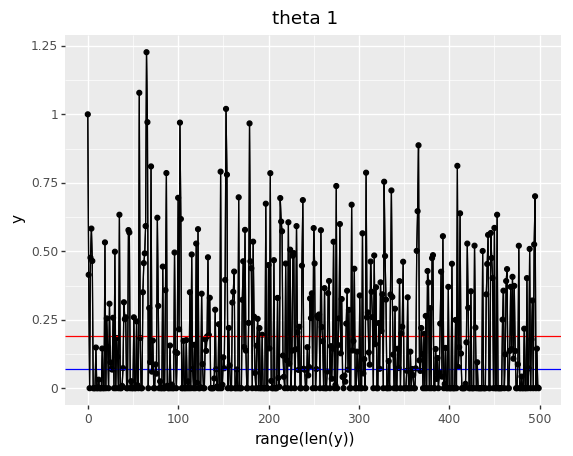

<ggplot: (300871516)>

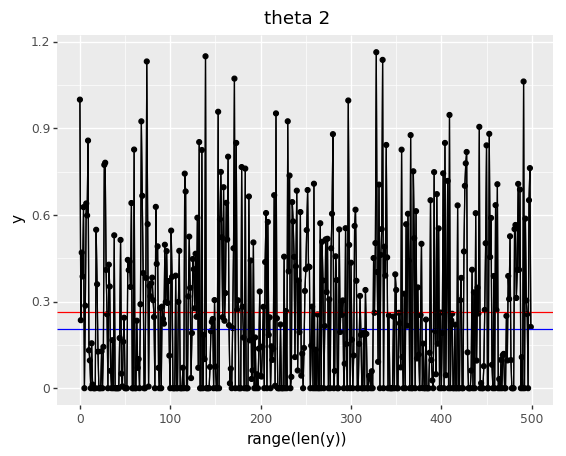

<ggplot: (302422953)>

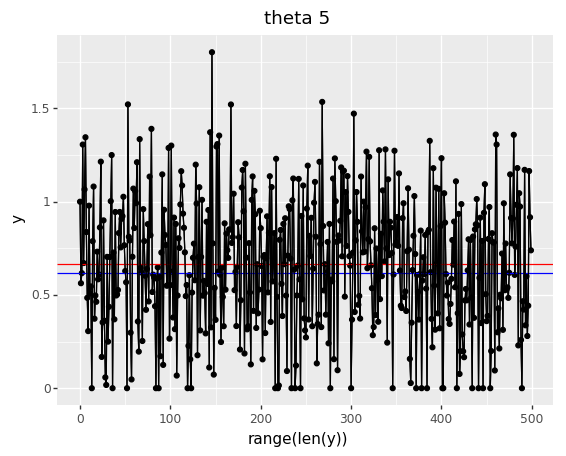

<ggplot: (-9223372036553339374)>

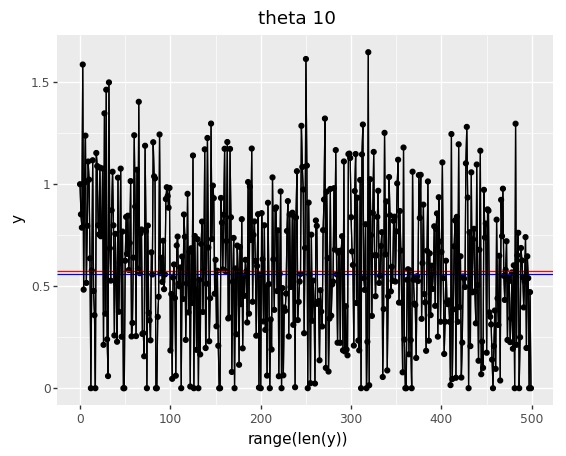

<ggplot: (-9223372036552212192)>

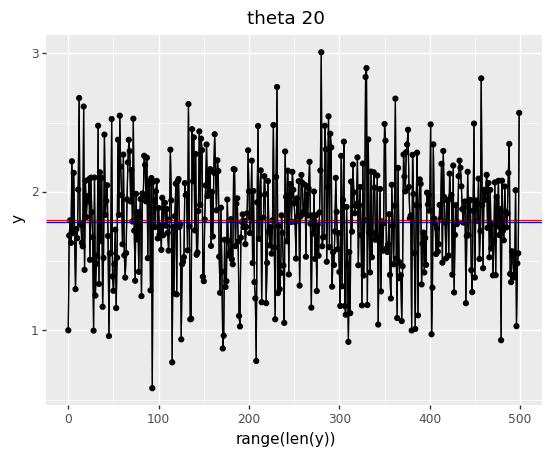

<ggplot: (301438314)>

In [18]:
# Plot a few days worth of estiamtes.
# the MCMC algorithm is supposed to "stabilize" over time. This stabilization is your "posterior distribution". 
# And we're able to take the mean of those values to get our estimate.
for i in [1, 2, 5, 10, 20]:
    r_mcmc.plot_theta(i)

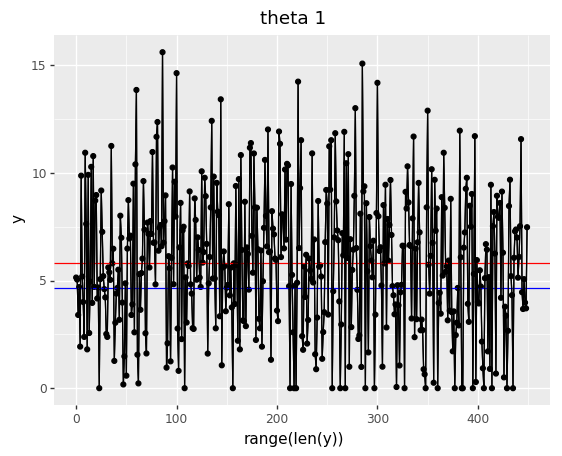

<ggplot: (-9223372036552079065)>

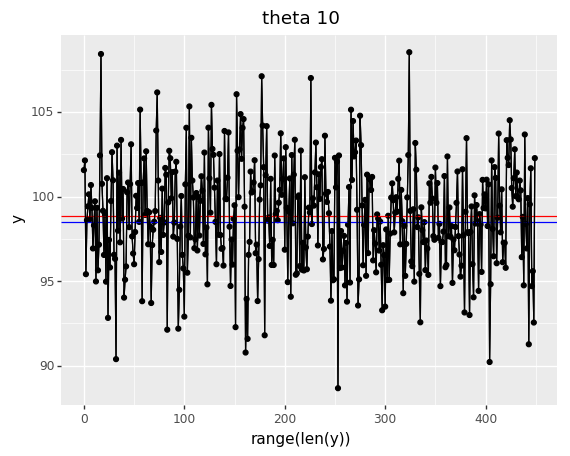

<ggplot: (302836407)>

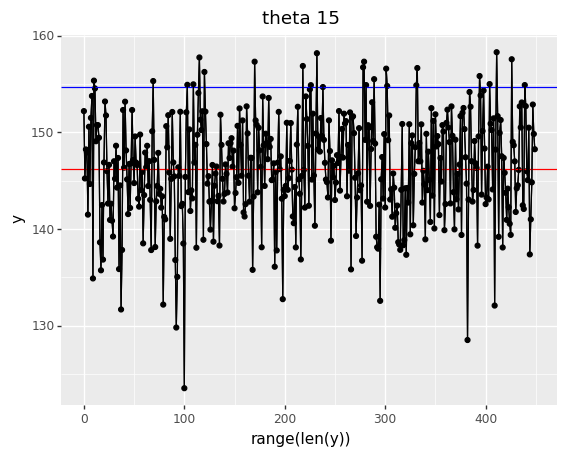

<ggplot: (-9223372036551832814)>

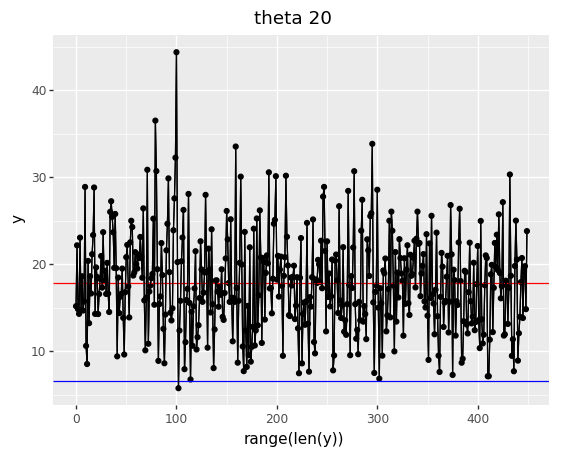

<ggplot: (-9223372036551832800)>

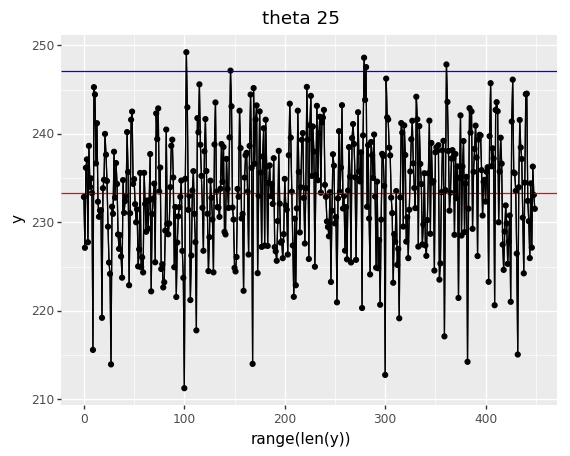

<ggplot: (-9223372036551612521)>

In [19]:
# Compare results for Cost
c_mcmc = MCMC(data=cost, niter=500)
c_mcmc.fit()

# Trace plots for 5 different days
for i in [1, 10, 15, 20, 25]:
    c_mcmc.plot_theta(i, burnin=False)

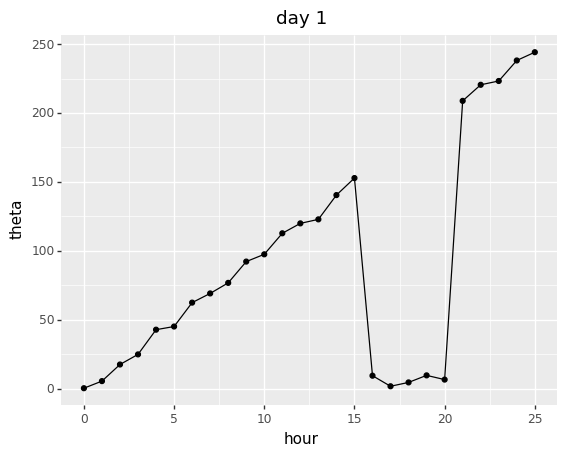

<ggplot: (301450844)>

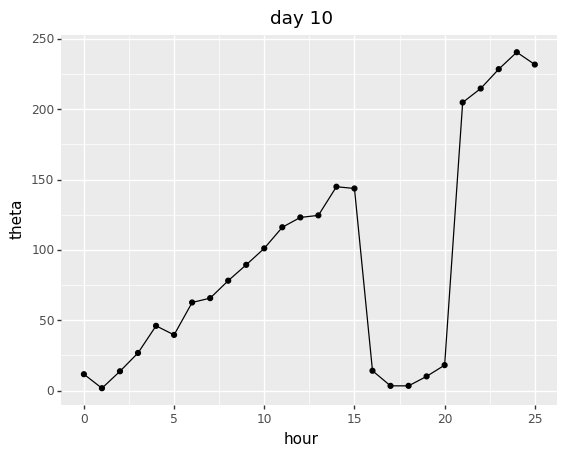

<ggplot: (303380337)>

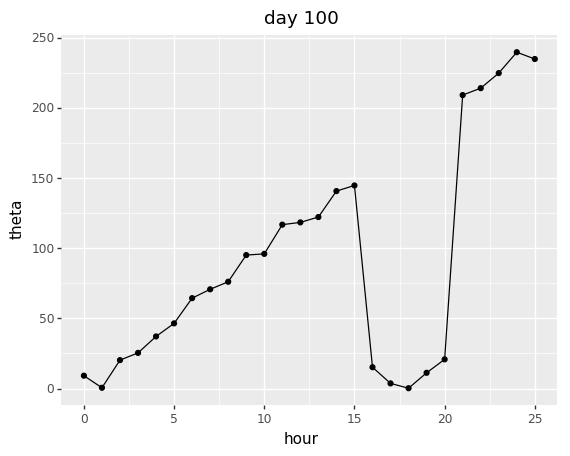

<ggplot: (303052103)>

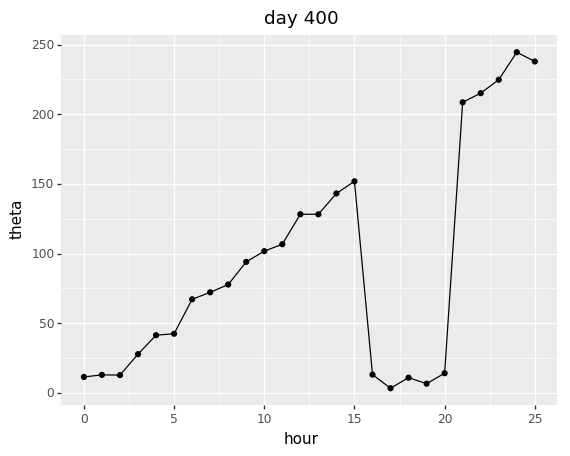

<ggplot: (301301361)>

In [20]:
# View performance across hours over days
for i in [1, 10, 100, 400]:
    c_mcmc.plot_day(i)

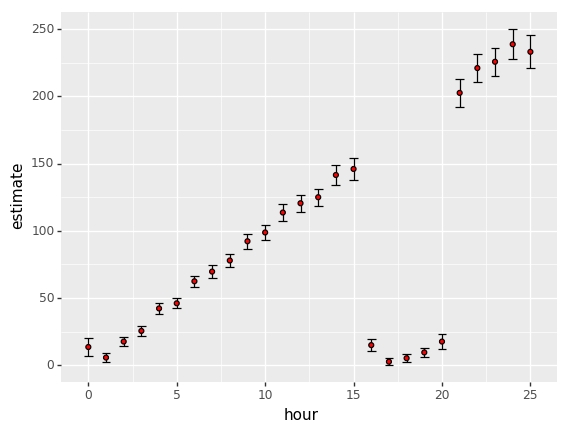

<ggplot: (-9223372036553732997)>

In [21]:
# Plot Estimated error bars. The truth values should just be day * 10 (day 5 should be 50)
# As you can see, the model is closely tied to surrounding values. This is an assumption built into the model, which 
# enforces that neighbor hours be correlated with each other.
c_mcmc.plot_hours()